## Introduction

This dataset consists of 101 animals from a zoo. There are 16 variables with various traits to describe the animals. The 7 Class Types are: Mammal, Bird, Reptile, Fish, Amphibian, Bug and Invertebrate

The purpose for this dataset is to be able to predict the classification of the animals, based upon the variables. It is the perfect dataset for those who are new to learning Machine Learning.

Attribute Information: (name of attribute and type of value domain)

- animal_name: Unique for each instance
- hair Boolean
- feathers Boolean
- eggs Boolean
- milk Boolean
- airborne Boolean
- aquatic Boolean
- predator Boolean
- toothed Boolean
- backbone Boolean
- breathes Boolean
- venomous Boolean
- fins Boolean
- legs Numeric (set of values: {0,2,4,5,6,8})
- tail Boolean
- domestic Boolean
- catsize Boolean
- class_type Numeric (integer values in range [1,7])


## Import libraries

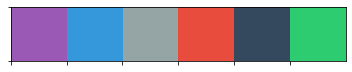

In [1]:
# Toolbox
import pandas as pd
import numpy as np
import random
import sys
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Statistics
from scipy.stats import norm

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Misc
import os
import warnings
warnings.filterwarnings(action='ignore')

# Preset data display
pd.options.display.max_seq_items = 1000
pd.options.display.max_rows =1000
pd.set_option('display.max_columns', 50)

# Set notebook colors and palette
flatui = ['#9b59b6', '#3498db', '#95a5a6', '#e74c3c', '#34495e', '#2ecc71']
sns.set_palette(flatui)
sns.palplot(sns.color_palette(flatui))
sns.set_style('white')
sns.set_color_codes(palette='deep')
# Favorite code to use: #34995e

In [2]:
import tensorflow as tf
import tensorflow.keras
import keras

print('These are the current versions working for me as of 2019-08-04')
print(f"TensorFlow Version: {tf.__version__}")
print(f"TensorFlow Keras Version: {tensorflow.keras.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print("TensorFlow-GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")
print(f"TensorFlow CUDA: {tf.test.is_built_with_cuda()}")
print(f"Tensorflow GPU Device Currently Activated: {tf.test.gpu_device_name()}")
print(f"Keras GPU: {keras.backend.tensorflow_backend._get_available_gpus()}")
print()
print(f"TF Session: {tf.Session()}")
print()
print(f"Python {sys.version}")

Using TensorFlow backend.


These are the current versions working for me as of 2019-08-04
TensorFlow Version: 1.13.1
TensorFlow Keras Version: 2.2.4-tf
Keras Version: 2.2.4

TensorFlow-GPU is available
TensorFlow CUDA: True
Tensorflow GPU Device Currently Activated: /device:GPU:0
Keras GPU: ['/job:localhost/replica:0/task:0/device:GPU:0']

TF Session: <tensorflow.python.client.session.Session object at 0x0000017476ABE668>

Python 3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]


### Define functions

In [3]:
def pct_bar_labels():
    '''
    Function used to label the relative frequency on top of each bars
    '''
    # Set font size
    fs=15
    
    # Set plot label and ticks
    plt.ylabel('Relative Frequency (%)', fontsize=fs)
    plt.xticks(rotation=0, fontsize=fs)
    plt.yticks([])
    
    # Set individual bar labels in proportional scale
    for x in ax1.patches:
        ax1.annotate(str(x.get_height()) + '%', 
        (x.get_x() + x.get_width()/2., x.get_height()), ha='center', va='center', xytext=(0, 7), 
        textcoords='offset points', fontsize=fs, color='black')

def freq_table(var):
    '''
    Define plot global variables
    Create a function that will populate a frequency table (%)
    Get counts per feature then get the percentage over the total counts
    '''
    global ax, ax1
    
    # Get Values and pct and combine it into a dataframe
    count_freq = var.value_counts()
    pct_freq = round(var.value_counts(normalize=True)*100, 2)
    
    # Create a dataframe
    df = pd.DataFrame({'Count': count_freq, 'Percentage': pct_freq})
    
    # Print variable name
    print('Frequency of', var.name, ':')
    display(df)
    
    # Create plot
    ax1 = pct_freq.plot.bar(title='Percentage of {}'.format(var.name), figsize=(12,8))
    ax1.title.set_size(15)
    pct_bar_labels()
    plt.show()
    
# Define a null function
def get_nulls(df):
    
    # Get null pct and counts
    null_cols = pd.DataFrame(df.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(df.isnull().sum().sort_values(ascending=False)/len(df),2), columns=['Null Data Pct'])

    # Combine dataframes horizontally
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data Pct']>0]

    # Print
    print('There are', len(all_nulls), 'columns with missing values.')
    return all_nulls

# Define plot_nulls function
def plot_nulls(train):
    # Get null pct and counts
    null_cols = pd.DataFrame(train.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(train.isnull().sum().sort_values(ascending=False)/len(train),2)*100, columns=['Null Data %'])

    # Combine horizontally (axis=1) into a dataframe with column names (keys=[]) then to a data frame
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data %']>0]

    # Create figure space
    plt.figure(figsize=(12, 8))

    # Create plot
    sns.barplot(x=all_nulls.index,
                y='Null Data %',
                data=all_nulls)

    # Set plot features
    plt.xticks(rotation='90')
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of Missing Values', fontsize=15)
    plt.title('Percent of Missing Data by Features', fontsize=15)
    plt.show()

## Load data

In [4]:
# Set directory
PATH = 'C:\\Users\\' + os.getlogin() + '\\Documents\\Programming\\MachineLearning\\Data'
os.chdir(PATH)
os.getcwd()
os.listdir()

['01-ign.csv',
 '02-winequality-red.csv',
 '02-winequality-white.csv',
 '03-thanksgiving-2015-poll-data.csv',
 '05-ibm-sales-loss.csv',
 '07-test.csv',
 '07-train.csv',
 '09-house-regression-env.db',
 '09-house-test.csv',
 '09-house-train.csv',
 '10-vgsales.csv',
 '11-diabetes.csv',
 '13-facebook-likes.csv',
 '15-google-review-ratings.csv',
 '16-mnist-test.csv',
 '16-mnist-train.csv',
 '17-real-estate-valuation.csv',
 '18-credit-card-defaults.csv',
 '20-zoo.csv',
 '21-breast-cancer.csv',
 'README.md']

In [6]:
train = pd.read_csv('20-zoo.csv')

In [7]:
train.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [8]:
train.shape

(101, 18)

In [9]:
get_nulls(train)

There are 0 columns with missing values.


,Null Data Count,Null Data Pct
